# Topic modelling
## r/conspiracy comments containing "vaccine"
**Group members**
* Maheep T
* Sanchi S
***

## Import modules

In [93]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re
import string
from dfply import *
import preprocessor as p
import unicodedata
import pickle
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from kwic import keywords_in_context
from operator import itemgetter
from datetime import datetime as dt
from keyness import log_likelihood

# download
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## Read files

In [2]:
base_dir = 'C:\\Users\\Maheep\\Documents\\TUM\\WiSe2020\\CSS\\code\\reddit-anti-vax' #import os; os.getcwd()
data_dir = base_dir + '\\data'

filename = data_dir + "\\" + "comments_vaccine_praw.csv" # comments_vaccine/_praw.csv
df_com = pd.read_csv(filename)
df_com = df_com.rename({'Submission ID': 's_id', 'Comment ID': 'c_id', 'Body': 'text', 'Publish Date': 'date', 'Author': 'user', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = data_dir + "\\" + "submissions_vaccine.csv"
df_sub = pd.read_csv(filename)
df_sub = df_sub.rename({'Post ID': 's_id', 'Title': 'text', 'Publish Date': 'date', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = data_dir + "\\" + "reddit_bots.csv"
df_bots = pd.read_csv(filename)
list_bots = df_bots['Name'].tolist() ;

In [ ]:
df_com['date'] =  df_com['date'].apply(lambda x: dt.strptime(x,'%Y-%m-%d %H:%M:%S')) # convert str to datetime

In [3]:
# out_file for temp output
out_file = base_dir + "\\" + "out_file.csv"

## Collect Data

* Use pushshift to query "vaccine" submissions (reddit posts)

In [4]:
print(df_sub.shape[0], " rows in submission data")

2905  rows in submission data


* Use PRAW to collect comments by iterating over all "vaccine" submissions
([praw docs](https://praw.readthedocs.io/en/latest/tutorials/comments.html))
    * pushshift comment data has a lot of missing values ([Gaffney, Matias 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0200162) )

In [5]:
print(df_com.shape[0], "rows in comment data")

77366 rows in comment data


## Clean-up and pre-processing

* Remove comments -
  * where user and text were [deleted]
  * where user is a  bot (list of bots from [Klein et. al. 2019](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0225098) )

In [39]:
df_com_pp = df_com.copy() # copy to pre-process dataframe
df_com_pp = df_com_pp >> mask(~((X.user == '[deleted]') & (X.text == '[deleted]'))) # >> summarize(count=n(X.c_id))
df_com_pp = df_com_pp[~df_com_pp['user'].isin(list_bots)]

In [40]:
# test, remove later
df_com_pp['text_og'] = df_com_pp['text']

* Clean - removes URLs, Hashtags, Mentions, Reserved words (RT, FAV), Emojis, Smileys ([Source](https://pypi.org/project/tweet-preprocessor/))

In [41]:
def func_clean(text):
    text = unicodedata.normalize("NFKC", text)  # remove unicode chars like emojis and breaks
    #text = re.sub(r'[^\x00-\x7F]+', " ", text)
    text = re.sub(r'[\r|\n|\r\n]+', " ", text) # remove extra newlines
    text = re.sub(r'[(){}[\]><]+', "", text) # remove brackets 
    text = re.sub(r'\/?u\/[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]', "", text) # remove user names
    text = p.clean(text) # from preprocessor lib
    return text
    
df_com_pp['text'] = df_com_pp['text'].apply(func_clean)

* Expanding contractions ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [42]:
from contractions import CONTRACTION_MAP
import re

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

df_com_pp['text'] = df_com_pp['text'].apply(expand_contractions)

* Tokenise <= lowercase + remove punctuation ([Source](https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e))

In [43]:
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.lower()) # lowercase
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))) # remove punctuation

tt = TweetTokenizer() # does better than default word_tokenizer
df_com_pp['text'] = df_com_pp['text'].apply(tt.tokenize) 

* Fix repetition in words e.g. "Coooolll!" => "Cool!" ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [44]:
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

df_com_pp['text'] = df_com_pp['text'].apply(remove_repeated_characters)

* Remove tokens that are integers

In [45]:
def func_filter_int(l):
    new_l = list()
    for tkn in l:
        tkn = re.sub(r'[-+*/$%.,]+', '', tkn)
        if not tkn.isnumeric() : new_l.append(tkn)
    return new_l

df_com_pp['text'] = df_com_pp['text'].apply(func_filter_int)

* Remove stopwords

In [46]:
stop_words = stopwords.words('english')
def func_filter_stopwords(l):
    return list([w for w in l if not w in stop_words])
df_com_pp['text'] = df_com_pp['text'].apply(func_filter_stopwords)

* ~~Stemming (not lemmatising as it needs the whole sentence context to be effective)~~

In [47]:
# ps = PorterStemmer()
# df_com_pp['text'] = df_com_pp['text'].apply(lambda x: [ps.stem(word) for word in x])


* Lemmatizing (preferred over a stemmer because it produces more readable words. Output that is easy to read is very desirable in topic modelling.) ([Source](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py))

In [48]:
lemmatizer = WordNetLemmatizer()
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

* save/load data because it takes long to do preprocessing

In [94]:
filename = data_dir + "\\" + "df_com_pp.dat"
# pickle.dump(df_com_pp, open(filename, 'wb')) # SAVE
# df_com_pp = pickle.load(open(filename, 'rb')) # LOAD

## Explore the data

* Weekly comment frequency on "vaccine" posts

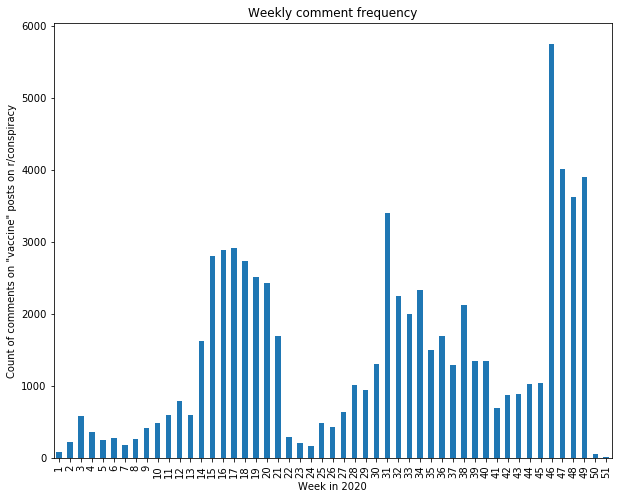

In [217]:
df_com_pp['week'] = pd.to_datetime(df_com_pp['date']).dt.isocalendar().week
df_new = df_com_pp.groupby('week').size()

fig = plt.figure(figsize=[10,8])
ax = plt.subplot()
ax = df_new.plot.bar()
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of comments on "vaccine" posts on r/conspiracy')
ax.set_title('Weekly comment frequency')
# #plt.grid()
plt.show()
# plt.cla()
# plt.clf()
# plt.close()
df_com_total = df_new.copy()

* Weekly comment frequency of comments mentioning "bill gate"

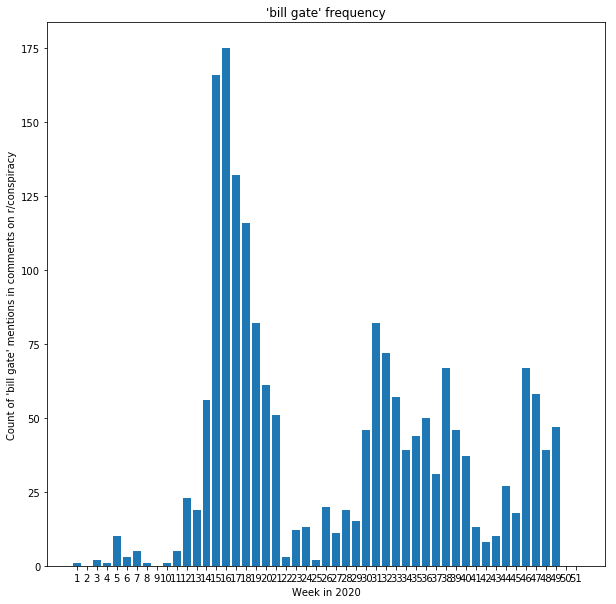

In [50]:
def func_gates(x):
    return True if (('bill' in x) & ('gate' in x)) else False
df_com_pp['gates'] = df_com_pp['text'].apply(lambda x: func_gates(x))
df_com_pp >> filter_by(X.gates == True)
df_new = df_com_pp.groupby('week').agg({'gates' : "sum"})


fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.bar(df_new.index,df_new['gates'].tolist())
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of \'bill gate\' mentions in comments on r/conspiracy')
ax.set_title('\'bill gate\' frequency')
# #plt.grid()
plt.show()

* Weekly comment frequency of comments mentioning "side effect"

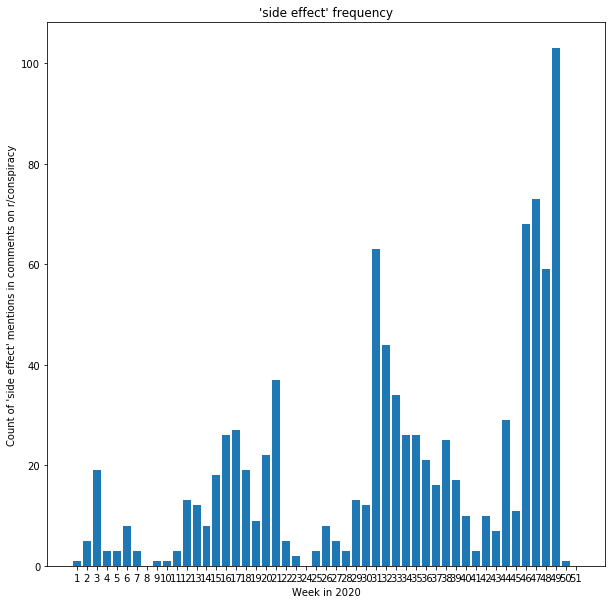

In [51]:
def func_effect(x):
    return True if (('side' in x) & ('effect' in x)) else False
df_com_pp['effect'] = df_com_pp['text'].apply(lambda x: func_effect(x))
df_new = df_com_pp.groupby('week').agg({'effect' : "sum"})


fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.bar(df_new.index,df_new['effect'].tolist())
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of \'side effect\' mentions in comments on r/conspiracy')
ax.set_title('\'side effect\' frequency')
# #plt.grid()
plt.show()

* Most important words/phrases ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch06%20-%20Text%20Summarization%20and%20Topic%20Models/Ch06a%20-%20Text%20Keyphrase%20Extraction.ipynb))

In [52]:
def compute_ngrams(sequence, n):
    return list(
            zip(*(sequence[index:] 
                     for index in range(n)))
    )

def get_top_ngrams(tokens, ngram_val=1, limit=5):

    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), 
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq) 
                     for text, freq in sorted_ngrams]

    return sorted_ngrams
list_tokens_flattened = [token for text in df_com_pp['text'].tolist() for token in text]
#get_top_ngrams(list_tokens_flattened,2,10)

In [53]:
get_top_ngrams(list_tokens_flattened,2,10)

[('bill gate', 1975),
 ('side effect', 1133),
 ('immune system', 988),
 ('covid vaccine', 860),
 ('flu shot', 814),
 ('flu vaccine', 778),
 ('long term', 757),
 ('take vaccine', 744),
 ('get vaccine', 740),
 ('big pharma', 619)]

In [54]:
get_top_ngrams(list_tokens_flattened,1,30)

[('vaccine', 28849),
 ('people', 16276),
 ('would', 10293),
 ('like', 9893),
 ('get', 9304),
 ('one', 8748),
 ('know', 7210),
 ('virus', 6801),
 ('think', 6459),
 ('even', 5824),
 ('u', 5808),
 ('covid', 5704),
 ('make', 5669),
 ('year', 5513),
 ('take', 5181),
 ('time', 5030),
 ('say', 4851),
 ('also', 4735),
 ('want', 4700),
 ('thing', 4666),
 ('right', 4322),
 ('go', 4056),
 ('dont', 4039),
 ('flu', 4000),
 ('work', 3943),
 ('see', 3921),
 ('need', 3850),
 ('going', 3827),
 ('good', 3806),
 ('way', 3795)]

* DFM ([Source](https://blog.koheiw.net/?p=468))

In [55]:
from gensim import corpora, models

print("Serialize tokens")
dic = corpora.Dictionary(df_com_pp['text'].tolist())

print("Construct a document-feature matrix")
mx = [dic.doc2bow(tok) for tok in df_com_pp['text'].tolist()]

print(dic)

Serialize tokens
Construct a document-feature matrix
Dictionary(36501 unique tokens: ['admit', 'anti', 'big', 'billion', 'campaign']...)


* Keyness (Sources [1](http://www.thegrammarlab.com/?p=193) [2](http://ucrel.lancs.ac.uk/llwizard.html))
  * The log_likelihood() function will return a rank ordered list with the following data in each item: - the item - its log likelihood value - its frequency in the corpus - its frequency in the reference corpus ([Source](https://github.com/mikesuhan/keyness))
  * ct.keyness() gives only effect sizes are reported (p values are arguably not particularly useful for keyness analyses). Keyness calculation options include "log-ratio", "%diff", and "odds-ratio". ([Source](https://github.com/kristopherkyle/corpus_toolkit))

In [56]:
#cutoff_date = dt(2020,10,1,0,0,0)
#cutoff_date = dt(2020,7,27,0,0,0) #Pfizer and BionTech start trials
cutoff_date = dt(2020,12,2,0,0,0) #Pfizer and BionTech start trials

df_temp = df_com_pp >> filter_by(X.date > cutoff_date)
corpus = df_temp['text'].tolist()

df_temp = df_com_pp >> filter_by(~(X.date > cutoff_date))
reference_corpus = df_temp['text'].tolist()

In [57]:
print("Cutoff date is ", cutoff_date)
log_likelihood(corpus, reference_corpus)

Cutoff date is  2020-12-02 00:00:00


[('wodarg', 199.876, 29, 0),
 ('yeadon', 197.997, 30, 1),
 ('spike', 187.159, 64, 154),
 ('message', 177.045, 69, 210),
 ('syncytin', 172.307, 25, 0),
 ('mrna', 168.157, 107, 628),
 ('protein', 158.991, 96, 532),
 ('ema', 146.772, 24, 3),
 ('hesitancy', 118.497, 25, 16),
 ('placenta', 107.03, 18, 3),
 ('gate', 94.687, 32, 3758),
 ('infertility', 94.381, 28, 50),
 ('trump', 91.955, 24, 3246),
 ('petition', 83.976, 25, 45),
 ('dr', 75.112, 77, 692),
 ('formation', 66.286, 14, 9),
 ('bot', 66.132, 42, 246),
 ('162b', 62.03, 9, 0),
 ('wolfgang', 62.03, 9, 0),
 ('eudract', 62.03, 9, 0),
 ('bill', 60.461, 25, 2648),
 ('flint', 60.181, 12, 6),
 ('pfizer', 58.768, 56, 476),
 ('polio', 56.193, 20, 2286),
 ('effect', 55.987, 145, 2167),
 ('duration', 54.446, 17, 34),
 ('biontech', 52.735, 14, 19),
 ('bnt', 51.729, 9, 2),
 ('worker', 51.11, 43, 330),
 ('dna', 50.801, 85, 1039),
 ('covid', 49.968, 283, 5421),
 ('unspecified', 48.729, 9, 3),
 ('manual', 47.724, 12, 14),
 ('eu', 46.722, 19, 62),
 ('

In [58]:
# from corpus_toolkit import corpus_tools as ct

# #First, generate frequency lists for each corpus
# corp1freq = ct.frequency(reference_corpus)
# corp2freq = ct.frequency(corpus)

# #then calculate Keyness
# corp_key = ct.keyness(corp1freq, corp2freq, effect = "log-ratio")
# ct.head(corp_key, hits = 10) #to display top hits

In [59]:
# corp1freq['bihar']

In [60]:
# df_temp = df_com >> filter_by(X.date > cutoff_date)
# df_temp['text'] = df_temp['text'].str.lower()
# KEYWORDS = ['bihar']
# for i in range(0,df_temp.shape[0]):
#     TEXT = df_temp[i,2]
#     keywords_in_context(TEXT, KEYWORDS)

---
## New stuff

In [61]:
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

finder = BigramCollocationFinder.from_documents(df_com_pp['text'].tolist())
finder

* Key nouns ???

In [62]:
bigram_measures = BigramAssocMeasures()                                                
finder.nbest(bigram_measures.raw_freq, 10)

[('bill', 'gate'),
 ('side', 'effect'),
 ('immune', 'system'),
 ('covid', 'vaccine'),
 ('flu', 'shot'),
 ('flu', 'vaccine'),
 ('long', 'term'),
 ('take', 'vaccine'),
 ('get', 'vaccine'),
 ('big', 'pharma')]

In [63]:
finder.nbest(bigram_measures.pmi, 20)

[('2020comentcomit', 'exebulshitcoment'),
 ('45f', '8c4'),
 ('4g', 'mol'),
 ('6pm', 'uzghu'),
 ('7h15', 'v43c1n35'),
 ('a72', 'loc'),
 ('abdulah', 'petrosaudi'),
 ('abey', 'chutiye'),
 ('abode', 'dexotique'),
 ('abu', 'ghraib'),
 ('acht', 'todesfle'),
 ('ack', 'eter'),
 ('acountmay', '2020comentcomit'),
 ('adenosine', 'triphosphate'),
 ('adis', 'ababa'),
 ('admonished', 'derided'),
 ('adventist', 'unitarian'),
 ('afrocentric', 'metaphysics'),
 ('ahed', 'tyme'),
 ('alba', 'pharmacal')]

In [64]:
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures

finder = TrigramCollocationFinder.from_documents(df_com_pp['text'].tolist())

In [65]:
trigram_measures = TrigramAssocMeasures()                                                
finder.nbest(trigram_measures.raw_freq, 10)

[('long', 'term', 'effect'),
 ('get', 'flu', 'shot'),
 ('bill', 'melinda', 'gate'),
 ('melinda', 'gate', 'foundation'),
 ('world', 'health', 'organization'),
 ('vaccine', 'cause', 'autism'),
 ('new', 'world', 'order'),
 ('term', 'side', 'effect'),
 ('long', 'term', 'side'),
 ('operation', 'warp', 'speed')]

In [66]:
finder.nbest(trigram_measures.pmi, 10)

[('7h15', 'v43c1n35', 'r3t4rd3d'),
 ('acht', 'todesfle', 'aufgrund'),
 ('acountmay', '2020comentcomit', 'exebulshitcoment'),
 ('adventist', 'unitarian', 'universalist'),
 ('alonal', 'alurate', 'antihistamine'),
 ('alors', 'pardonez', 'moi'),
 ('alurate', 'antihistamine', 'cal'),
 ('am3', '7h15', 'v43c1n35'),
 ('arinjay', 'banerje', 'postdoctoral'),
 ('astringosol', 'campho', 'phenique')]

---
## Latent Dirichlet Allocation
([Source](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py))

We find bigrams in the documents. Bigrams are sets of two adjacent words. Using bigrams we can get phrases like “machine_learning” in our output (spaces are replaced with underscores); without bigrams we would only get “machine” and “learning”.

Note that in the code below, we find bigrams and then add them to the original data, because we would like to keep the words “machine” and “learning” as well as the bigram “machine_learning”.

In [70]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(df_com_pp['text'].tolist(), min_count=20)
for idx in range(len(df_com_pp['text'].tolist())):
    for token in bigram[df_com_pp['text'].tolist()[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            #docs[idx].append(token)
            df_com_pp.iloc[idx, df_temp.columns.get_loc('text')].append(token)

* Remove rare words and common words based on their document frequency 

Remove words that appear in less than 20 documents or in more than 50% of the documents.

In [71]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(df_com_pp['text'].tolist())

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

Finally, we transform the documents to a vectorized form. We simply compute the frequency of each word, including the bigrams.

In [72]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in df_com_pp['text'].tolist()]

Let’s see how many tokens and documents we have to train on.

In [73]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6913
Number of documents: 71441


### Training

First of all, the elephant in the room: how many topics do I need? There is really no easy answer for this, it will depend on both your data and your application. I have used 10 topics here because I wanted to have a few topics that I could interpret and “label”, and because that turned out to give me reasonably good results. You might not need to interpret all your topics, so you could use a large number of topics, for example 100.

chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. I’ve set chunksize = 2000, which is more than the amount of documents, so I process all the data in one go. Chunksize can however influence the quality of the model, as discussed in Hoffman and co-authors [2], but the difference was not substantial in this case.

passes controls how often we train the model on the entire corpus. Another word for passes might be “epochs”. iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

I suggest the following way to choose iterations and passes. First, enable logging (as described in many Gensim tutorials), and set eval_every = 1 in LdaModel. When training the model look for a line in the log that looks something like this:
> 2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations

If you set passes = 20 you will see this line 20 times. Make sure that by the final passes, most of the documents have converged. So you want to choose both passes and iterations to be high enough for this to happen.

We set alpha = 'auto' and eta = 'auto'. Again this is somewhat technical, but essentially we are automatically learning two parameters in the model that we usually would have to specify explicitly.

In [84]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [1]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

NameError: name 'dictionary' is not defined

In [77]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -4.8109.
[([(0.030418435, 'people'),
   (0.02693946, 'vaccine'),
   (0.018902114, 'would'),
   (0.01847661, 'get'),
   (0.014696773, 'like'),
   (0.013943623, 'one'),
   (0.011784155, 'know'),
   (0.011685759, 'think'),
   (0.011190909, 'take'),
   (0.009956165, 'u'),
   (0.009841269, 'make'),
   (0.008724624, 'want'),
   (0.008577285, 'time'),
   (0.00833719, 'even'),
   (0.008066242, 'thing'),
   (0.007703847, 'dont'),
   (0.0074968003, 'go'),
   (0.0074620554, 'need'),
   (0.00742818, 'say'),
   (0.007347669, 'see')],
  -2.051992713930376),
 ([(0.045650396, 'virus'),
   (0.04052872, 'covid'),
   (0.018898845, 'death'),
   (0.01825703, 'immune_system'),
   (0.016082533, 'test'),
   (0.014353074, 'flu'),
   (0.01365765, 'vaccine'),
   (0.013345047, 'immune'),
   (0.01278575, 'mrna'),
   (0.012499983, 'cell'),
   (0.011824681, 'dna'),
   (0.01069974, 'body'),
   (0.010587206, 'system'),
   (0.01017955, 'disease'),
   (0.009467146, 'protein'),
   (0.009463581, '

In [367]:
logging.disable(logging.WARNING)

In [368]:
model_lda = model
for topic_id, topic in model_lda.print_topics(num_topics=num_topics, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.023*"wearing" + 0.022*"normal" + 0.020*"good_luck" + 0.019*"swine_flu" + 0.018*"pretty_sure" + 0.016*"either_way" + 0.015*"submission_statement" + 0.014*"back_normal" + 0.010*"ah" + 0.010*"body" + 0.009*"test_subject" + 0.009*"success_rate" + 0.009*"luck" + 0.009*"ah_yes" + 0.009*"body_choice" + 0.008*"give_fuck" + 0.008*"previous" + 0.008*"human_body" + 0.008*"swine" + 0.007*"return"

Topic #2:
0.027*"drug" + 0.022*"pfizer" + 0.016*"herd_immunity" + 0.016*"billion" + 0.016*"company" + 0.015*"go_back" + 0.013*"industry" + 0.012*"pharmaceutical_company" + 0.011*"million" + 0.011*"rockefeller" + 0.010*"great_reset" + 0.010*"pharmaceutical" + 0.010*"pay" + 0.009*"dollar" + 0.008*"every_day" + 0.008*"pharmaceutical_industry" + 0.008*"billion_dollar" + 0.007*"herd" + 0.007*"merck" + 0.007*"around_world"

Topic #3:
0.092*"bill_gate" + 0.055*"gate" + 0.041*"bill" + 0.031*"let_u" + 0.027*"look_like" + 0.024*"year_old" + 0.020*"seems_like" + 0.019*"conspiracy_theorist" + 0.017*"last

In [366]:
topics_coherences = model_lda.top_topics(corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -4.8108934130260845


In [458]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_lda, texts=df_com_pp['text'].tolist(), dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4326611448740696


In [371]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([ (term) for wt, term in topic]) # (term, round(wt, 3))
    print()

LDA Topics with Weights
Topic #1:
['people', 'vaccine', 'would', 'get', 'like', 'one', 'know', 'think', 'take', 'u', 'make', 'want', 'time', 'even', 'thing', 'dont', 'go', 'need', 'say', 'see']

Topic #2:
['virus', 'covid', 'death', 'immune_system', 'test', 'flu', 'vaccine', 'immune', 'mrna', 'cell', 'dna', 'body', 'system', 'disease', 'protein', 'spike_protein', 'sars_cov', 'pcr_test', 'rna', 'coronavirus']

Topic #3:
['conspiracy', 'fact', 'read', 'lot', 'use', 'also', 'doctor', 'like', 'find', 'show', 'question', 'science', 'medical', 'wrong', 'article', 'could', 'source', 'actually', 'sound_like', 'dont_know']

Topic #4:
['vaccine', 'study', 'health', 'trial', 'big_pharma', 'polio', 'anti_vax', 'vaccination', 'rate', 'case', 'year', 'vax', 'group', 'public_health', 'fda', 'anti', 'clinical_trial', 'pharma', 'adverse_reaction', 'cdc']

Topic #5:
['vaccine', 'side_effect', 'long_term', 'effect', 'long', 'side', 'term', 'vaccinated', 'child', 'safe', 'risk', 'cause', 'get_sick', 'kid'

In [439]:
tm_results = model_lda[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(6, 0.2906104),
 (6, 0.3606272),
 (4, 0.39724436),
 (4, 0.42858043),
 (4, 0.295783)]

In [374]:
topics = [[(term, round(wt, 3)) 
               for term, wt in model_lda.show_topic(n, topn=20)] 
                   for n in range(0, model_lda.num_topics)]
df_topics = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, model_lda.num_topics+1)]
                         )
df_topics

,Terms per Topic
Topic1,"wearing, normal, good_luck, swine_flu, pretty_sure, either_way, submission_statement, back_normal, ah, body, test_subject, success_rate, luck, ah_yes, body_choice, give_fuck, previous, human_body,..."
Topic2,"drug, pfizer, herd_immunity, billion, company, go_back, industry, pharmaceutical_company, million, rockefeller, great_reset, pharmaceutical, pay, dollar, every_day, pharmaceutical_industry, billio..."
Topic3,"bill_gate, gate, bill, let_u, look_like, year_old, seems_like, conspiracy_theorist, last_year, getting_sick, high_risk, old, hundred_thousand, front, mandatory_vaccination, stay_home, read_article..."
Topic4,"virus, covid, death, immune_system, test, flu, vaccine, immune, mrna, cell, dna, body, system, disease, protein, spike_protein, sars_cov, pcr_test, rna, coronavirus"
Topic5,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see"
Topic6,"control, government, state, every_year, power, business, world, order, plan, fake, uk, population, china, company, law, r, global, message, new, month_ago"
Topic7,"vaccine, study, health, trial, big_pharma, polio, anti_vax, vaccination, rate, case, year, vax, group, public_health, fda, anti, clinical_trial, pharma, adverse_reaction, cdc"
Topic8,"im, got, lol, flu_shot, make_sense, shot, year, flu, fucking, comment, youre, survival_rate, sense, sub, oh, year_ago, thanks, isnt, ive, thinking"
Topic9,"vaccine, side_effect, long_term, effect, long, side, term, vaccinated, child, safe, risk, cause, get_sick, kid, get_vaccinated, autism, tested, would_rather, guinea_pig, effective"
Topic10,"conspiracy, fact, read, lot, use, also, doctor, like, find, show, question, science, medical, wrong, article, could, source, actually, sound_like, dont_know"


In [411]:
df_corpus_topic = pd.DataFrame()
df_corpus_topic['Document'] = range(1, len(df_com_pp['text'].tolist())+1)
df_corpus_topic['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
df_corpus_topic['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
df_corpus_topic['Topic Desc'] = [df_topics.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
df_corpus_topic['Paper'] = df_com_pp['text_og'].tolist()

* Dominant Topics Distribution across Corpus

In [414]:
df_corpus_topic.head(2)

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
0,1,7,29.06000,"vaccine, study, health, trial, big_pharma, polio, anti_vax, vaccination, rate, case, year, vax, group, public_health, fda, anti, clinical_trial, pharma, adverse_reaction, cdc","Submission statement: The vaccine industry presents itself as vital and infallible, yet they have consistently covered up evidence of the phenomenon known as ""vaccine injury"". Vaccine manufacturer..."
1,2,7,36.06000,"vaccine, study, health, trial, big_pharma, polio, anti_vax, vaccination, rate, case, year, vax, group, public_health, fda, anti, clinical_trial, pharma, adverse_reaction, cdc","Vaccines are a bioweapon. They turn kids into cash cows for big pharma, and they bear no liability for it whatsoever. It is disgusting, our politicians, health agencies, and science are bought b..."


In [435]:
#pd.set_option('display.max_colwidth', 200)
df_topic_stats = df_corpus_topic.groupby('Dominant Topic').agg(count=('Document','count')).reset_index()
df_topic_stats = df_topic_stats.rename(columns={'count':'Doc Count'})
df_topic_stats['% Total Docs'] = df_topic_stats['Doc Count'].apply(lambda row: round((row*100) / df_com_pp['text'].size, 2))
df_topic_stats['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(df_topic_stats))]
df_topic_stats

,Dominant Topic,Doc Count,% Total Docs,Topic Desc
0,1,90,0.13000,"vaccine, child, side_effect, polio, vaccine_injury, autism, injury, get, effect, take, covid, flu, safe, covid vaccine, vaccination, risk, case, study, disease, health"
1,2,309,0.43000,"people, would, like, get, one, know, think, u, even, thing, make, want, say, time, right, take, covid, dont, go, year"
2,3,341,0.48000,"npafp_rate, npafp, rate, polio, npafp rate, year, pulse_polio, case_npafp, round, pulse polio, pulse, number, state, child, case, found, five_year, correlation, p, previous_year"
3,4,1912,2.68000,"bill_gate, gate, bill, bill_gate bill_gate, bill gate, gate_foundation, world, foundation, u, china, bill_melinda, gate foundation, health, conspiracy_theory, health_organization, epstein, bill_me..."
4,5,61936,86.70000,"rockefeller, drug, rockefeller_foundation, john_hopkins, united_state, medical, foundation, drug_trust, rockefeller foundation, medicine, trust, world, state, drug_story, call_tune, china, john, d..."
5,6,296,0.41000,"body, activity, may, sensor, user, human, wave, brain, human_body, example, quantum_dot, flow, data, blood, e_g, system, device, movement, one, task"
6,7,1407,1.97000,"vaccine, adverse_reaction, control_group, trial, clinical_trial, drug, hepatitis_b, adverse, licensed, day, one, fda, inert_placebo, control, group, safety, placebo, study, reaction, united_state"
7,8,515,0.72000,"hpv_vaccine, hpv, cervical_cancer, vaccine, hpv vaccine, cancer, long_term, clinical_trial, cervical, vaccination, cervical cancer, safety, trial, study, year_old, efficacy, hpv_vaccine hpv_vaccin..."
8,9,808,1.13000,"virus, immune_system, immune, cell, sars_cov, system, immune system, covid, disease, sars, dna, immune_system immune_system, human, coronavirus, test, new, infection, also, flu, protein"
9,10,3827,5.36000,"million, drug, pay_million, pay, merck, settle, case, flu, u, billion, flu_shot, kickback, company, pharmaceutical_company, pfizer, fraud, pay million, pay_billion, lawsuit, pharmaceutical_industry"


* Dominant Topics in Specific Research Papers

In [443]:
#pd.set_option('display.max_colwidth', 200)
(df_corpus_topic[df_corpus_topic['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
8,9,5,41.09000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see",Well in many ways it makes a lot of sense if you think of their likely agenda here. (we are in a conspiracy sub after all)
12,13,5,41.04000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see","I wrote that there is no study. At all. It was never ""prooved to work so long ago"" or anytime since. Vaccination is void of science to defend it, but that's a lovely bibliography."
16,17,5,35.19000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see","Unless you believe the anthrax scare was manufactured (because all the anthrax found & tested were from labs in Iowa, not some Isis bs propaganda) and in that case they created a problem then sold..."
391,392,5,33.90000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see",I hurt the dependa’s feeling 😞
502,503,5,40.96000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see","On the inserts of some vaccines it literally says stuff like, “can cause SIDS, autism...” and a bunch of other shit and then you have disinfo people on here acting like one doctor just made it up ..."
680,681,5,40.31000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see","To think just a couple of years ago I felt alone in my decisions and research. Felt like being attacked everywhere and now, welcome my brothers and sister ❤️ big hugs"
732,733,5,30.34000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see",">last 30 years There have been 8,087 vaccine-related deaths reported to VAERS, but that number likely represents only one percent of the total number of deaths that have actually occurred and the ..."
905,906,5,46.81000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see",A simple yes or no would do.
995,996,5,34.59000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see",To pump infants with more vaccines
1621,1622,5,54.50000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see",The unscrupulous parasitic traitors against mankind that manage us to serve their own interests find the allowance of injectables against the will of the individual to be advantageous. They so own...


* Relevant Research Papers per Topic based on Dominance

In [444]:
df_corpus_topic.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,4985,1,43.49000,"wearing, normal, good_luck, swine_flu, pretty_sure, either_way, submission_statement, back_normal, ah, body, test_subject, success_rate, luck, ah_yes, body_choice, give_fuck, previous, human_body,...",Good luck on your journey. It’s a deep rabbit hole.
2,1530,2,93.43000,"drug, pfizer, herd_immunity, billion, company, go_back, industry, pharmaceutical_company, million, rockefeller, great_reset, pharmaceutical, pay, dollar, every_day, pharmaceutical_industry, billio...","These are the companies you trust. Lol \n\n\n>Ah, but what they can’t dispute is the pharmaceutical industry is rife with corruption.\n>Fraudulent tests. bribery, kickbacks to doctors, blackmail, ..."
3,8456,3,53.88000,"bill_gate, gate, bill, let_u, look_like, year_old, seems_like, conspiracy_theorist, last_year, getting_sick, high_risk, old, hundred_thousand, front, mandatory_vaccination, stay_home, read_article...",>Bill Gates is evil \n> \n>Bill Gates is sterilizing the negro hordes\n\nWhich is it?
4,57730,4,75.46000,"virus, covid, death, immune_system, test, flu, vaccine, immune, mrna, cell, dna, body, system, disease, protein, spike_protein, sars_cov, pcr_test, rna, coronavirus","the MRNA vaccine is instructions to build certain proteins, spike proteins. The idea is then these spike proteins present in SARS-CoV2 would be identified more rapidly for destruction by our immun..."
5,1946,5,82.71000,"people, vaccine, would, get, like, one, know, think, take, u, make, want, time, even, thing, dont, go, need, say, see",I think It’s the Chinese people leading their society into lifestyle with world war 3 going on behind the scenes. The CCP seems to not want to let their people know that the US is pretty much cutt...
6,8494,6,71.76000,"control, government, state, every_year, power, business, world, order, plan, fake, uk, population, china, company, law, r, global, message, new, month_ago",r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchredditdie r/watchre...
7,11241,7,91.51000,"vaccine, study, health, trial, big_pharma, polio, anti_vax, vaccination, rate, case, year, vax, group, public_health, fda, anti, clinical_trial, pharma, adverse_reaction, cdc","https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6121585/pdf/ijerph-15-01755.pdf\n\n""The last case of polio from India was reported in 2011. That year, the non-polio acute flaccid paralysis (NPAFP) ra..."
8,21187,8,84.67000,"im, got, lol, flu_shot, make_sense, shot, year, flu, fucking, comment, youre, survival_rate, sense, sub, oh, year_ago, thanks, isnt, ive, thinking","We've removed this comment per rule 2, as we ask that you address the argument rather than the user when commenting outside of the meta sticky comment. If you remove the section of your comment di..."
9,1760,9,61.12000,"vaccine, side_effect, long_term, effect, long, side, term, vaccinated, child, safe, risk, cause, get_sick, kid, get_vaccinated, autism, tested, would_rather, guinea_pig, effective","The National Childhood Vaccine Injury Act of 1986 provides immunity to vaccine manufacturers. Vaccine injury/deaths have to go through a federal vaccine injury court and if successful, are paid o..."


In [80]:
# Save model to disk.
filename = data_dir + "\\" + "ldamodel"
model.save(filename)

* Plots

In [445]:
df_com_pp['topic_lda'] = df_corpus_topic['Dominant Topic']

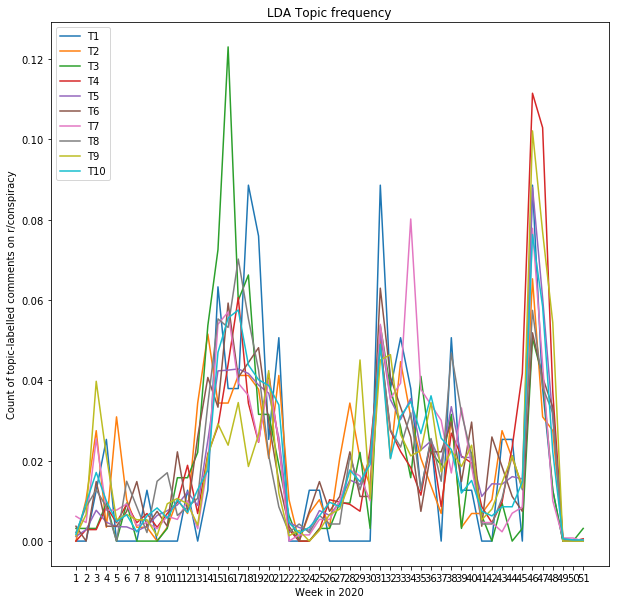

In [451]:
df_new = df_com_pp.groupby(['topic_lda', 'week']).size().unstack('topic_lda', fill_value = 0)
df_new.columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']

# # normalise by dividing each row by total coms that week
# for i in df_com_total.index:
#     df_new.loc[i] = df_new.loc[i]/df_com_total.loc[i]

# normalise by dividing each column by total coms of that topic
df_new = df_new.divide(df_new.sum(axis=0), axis = 'columns')

fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.plot(df_new.index,df_new)
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of topic-labelled comments on r/conspiracy')
ax.set_title('LDA Topic frequency')
ax.legend(df_new.columns, loc='upper left')
# #plt.grid()
plt.show()

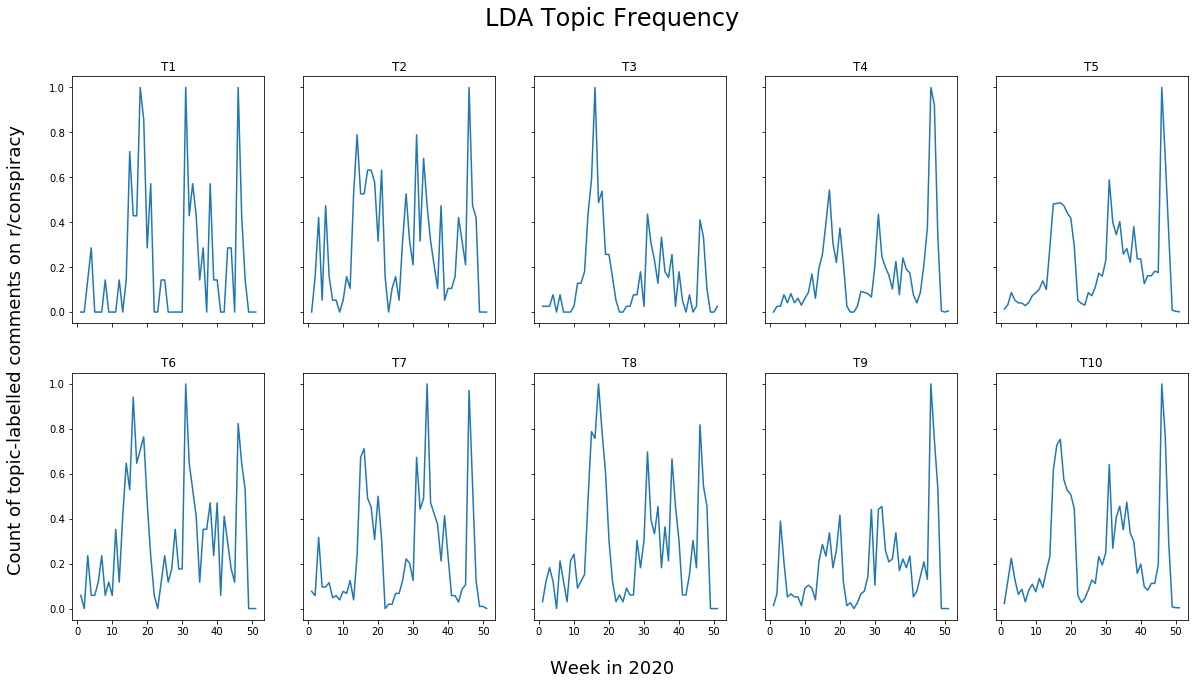

In [454]:
df_new = df_com_pp.groupby(['topic_lda', 'week']).size().unstack('topic_lda', fill_value = 0)
df_new.columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']

# normalise by dividing each column by max/total weekly count of comments with that topic
df_new = df_new.divide(df_new.max(axis=0), axis = 'columns')

fig, ax = plt.subplots(2,5, sharex='col', sharey='row')
fig.set_size_inches([20,10])
idx = 0
for i in range(2):
    for j in range(5):
        ax[i, j].plot(df_new.index,df_new.iloc[:,idx])
        ax[i, j].set_title(df_new.columns[idx])
        idx+=1
fig.text(0.5, 0.95, 'LDA Topic Frequency', ha='center', fontsize=24)
fig.text(0.5, 0.05, 'Week in 2020', ha='center', fontsize=18)
fig.text(0.08, 0.5, 'Count of topic-labelled comments on r/conspiracy', va='center', rotation='vertical', fontsize=18)
plt.show()

---
## Non-negative Matrix Factorisation

Topic Models with Non-Negative Matrix Factorization (NMF)

([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch06%20-%20Text%20Summarization%20and%20Topic%20Models/Ch06c%20-%20Topic%20Modeling%20with%20scikit-learn.ipynb)) - Sarkar, Text Analytics in Python

Alternate - NMF using sklearn ([Source](https://gist.github.com/ravishchawla/3f346318b85fa07196b761443b123bba))

In [333]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2),
                     token_pattern=None, tokenizer=lambda doc: doc,
                     preprocessor=lambda doc: doc)
cv_features = cv.fit_transform(df_com_pp['text']) #Learn the vocabulary dictionary (fit) and return document-term matrix (transform)
cv_features.shape
vocabulary = np.array(cv.get_feature_names())
print('Total Vocabulary Size:', len(vocabulary))

Total Vocabulary Size: 11422


* tf-Idf transformation

In [334]:
# transformer = TfidfTransformer(smooth_idf=False);
# cv_features = transformer.fit_transform(cv_features);

# from sklearn.preprocessing import normalize;
# cv_features = normalize(cv_features, norm='l1', axis=1)

In [567]:
%%time
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=num_topics, solver='cd', max_iter=2000,
                random_state=42, alpha=.1, l1_ratio=.85)
document_topics = nmf_model.fit_transform(cv_features)

C:\Users\Maheep\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


Wall time: 1min 42s


In [574]:
top_terms=20
topic_terms = nmf_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame(topics,
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, num_topics+1)])
topics_df

,Terms per Topic
Topic1,"vaccine, child, side_effect, polio, vaccine_injury, autism, injury, get, effect, take, flu, covid, safe, covid vaccine, vaccination, risk, case, study, disease, health"
Topic2,"people, would, like, get, one, know, think, u, even, make, thing, want, say, time, right, take, covid, dont, go, year"
Topic3,"npafp_rate, npafp, rate, polio, npafp rate, year, pulse_polio, case_npafp, round, pulse polio, pulse, number, state, child, case, found, five_year, correlation, p, previous_year"
Topic4,"bill_gate, gate, bill, bill_gate bill_gate, bill gate, gate_foundation, world, foundation, u, china, bill_melinda, gate foundation, health, conspiracy_theory, health_organization, epstein, bill_me..."
Topic5,"rockefeller, drug, rockefeller_foundation, john_hopkins, united_state, medical, foundation, drug_trust, rockefeller foundation, medicine, trust, world, state, drug_story, call_tune, china, john, d..."
Topic6,"body, activity, may, sensor, user, human, wave, brain, human_body, example, quantum_dot, flow, data, blood, e_g, system, device, movement, one, task"
Topic7,"vaccine, adverse_reaction, control_group, trial, clinical_trial, drug, hepatitis_b, adverse, licensed, day, one, fda, inert_placebo, control, group, safety, placebo, study, reaction, united_state"
Topic8,"hpv_vaccine, hpv, cervical_cancer, vaccine, hpv vaccine, cancer, long_term, clinical_trial, cervical, vaccination, cervical cancer, safety, trial, study, year_old, efficacy, hpv_vaccine hpv_vaccin..."
Topic9,"virus, immune_system, immune, cell, sars_cov, system, immune system, covid, disease, sars, dna, immune_system immune_system, human, coronavirus, test, new, infection, also, flu, protein"
Topic10,"million, drug, pay_million, pay, merck, settle, case, flu, u, billion, flu_shot, kickback, company, pharmaceutical_company, pfizer, fraud, pay million, pay_billion, lawsuit, pharmaceutical_industry"


* Viewing topic dominance per document using the document-topic matrix

In [569]:
pd.options.display.float_format = '{:,.3f}'.format
dt_df = pd.DataFrame(document_topics, 
                     columns=['T'+str(i) for i in range(1, num_topics+1)])
dt_df.head(5)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.112,0.000,0.000,0.000,0.005,0.014,0.000,0.000,0.000,0.028
1,0.030,0.016,0.000,0.002,0.024,0.004,0.000,0.000,0.000,0.028
2,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000
4,0.027,0.000,0.000,0.000,0.000,0.018,0.000,0.000,0.011,0.000


* determine the most relevant comment for each topic based on the topic dominance scores 

In [570]:
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_score_topics = dt_df.max(axis=0)
dominant_topics = max_score_topics.index
term_score = max_score_topics.values
document_numbers = [dt_df[dt_df[t] == max_score_topics.loc[t]].index[0]
                       for t in dominant_topics]
documents = [df_com.iloc[i, df_com.columns.get_loc('text')] for i in document_numbers]

results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Max Score': term_score,
                          'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'], 
                          'Paper Name': documents})
results_df

,Dominant Topic,Max Score,Paper Num,Topic,Paper Name
Topic1,T1,1.10608,5061,"vaccine, child, side_effect, polio, vaccine_injury, autism, injury, get, effect, take, flu, covid, safe, covid vaccine, vaccination, risk, case, study, disease, health","What I think is:\n(Regarding initial discussion with other user)\nIf you are just trying to bring a potential danger to light, I agree with you. If you are trying to say all vaccines will do this,..."
Topic2,T2,0.60757,6092,"people, would, like, get, one, know, think, u, even, make, thing, want, say, time, right, take, covid, dont, go, year",Don’t get the vaccine.
Topic3,T3,3.49776,12032,"npafp_rate, npafp, rate, polio, npafp rate, year, pulse_polio, case_npafp, round, pulse polio, pulse, number, state, child, case, found, five_year, correlation, p, previous_year","Weird analogy since the majority of people will need to call a plumber more than once in their life. If you want to use that analogy though, consider that there are instead 131 identified pipes, a..."
Topic4,T4,1.19678,3840,"bill_gate, gate, bill, bill_gate bill_gate, bill gate, gate_foundation, world, foundation, u, china, bill_melinda, gate foundation, health, conspiracy_theory, health_organization, epstein, bill_me...",That's something to think about. It's far enough in the future that I'm sure there might be ways to get out of it but idk. I feel like people who don't get this vaccine will have a huge target ove...
Topic5,T5,3.61466,26596,"rockefeller, drug, rockefeller_foundation, john_hopkins, united_state, medical, foundation, drug_trust, rockefeller foundation, medicine, trust, world, state, drug_story, call_tune, china, john, d...",Mercury in any form I don't want in my body
Topic6,T6,4.00991,18227,"body, activity, may, sensor, user, human, wave, brain, human_body, example, quantum_dot, flow, data, blood, e_g, system, device, movement, one, task",Do you have proof its safe. I like to see an opposite opinion with as many references.
Topic7,T7,3.36726,35069,"vaccine, adverse_reaction, control_group, trial, clinical_trial, drug, hepatitis_b, adverse, licensed, day, one, fda, inert_placebo, control, group, safety, placebo, study, reaction, united_state","I'm not going to quote the press releases for you. If you don't believe me, read them yourself."
Topic8,T8,6.00537,1793,"hpv_vaccine, hpv, cervical_cancer, vaccine, hpv vaccine, cancer, long_term, clinical_trial, cervical, vaccination, cervical cancer, safety, trial, study, year_old, efficacy, hpv_vaccine hpv_vaccin...",Good thing this attitude isn't widespread or we'd be fucked as a society.
Topic9,T9,1.91031,51784,"virus, immune_system, immune, cell, sars_cov, system, immune system, covid, disease, sars, dna, immune_system immune_system, human, coronavirus, test, new, infection, also, flu, protein",SS:\n\nThe United Nations has been forced to admit that a major international vaccine initiative is actually causing the outbreak of the very disease it was supposed to wipe-out.\n\nWhile internat...
Topic10,T10,3.94644,30052,"million, drug, pay_million, pay, merck, settle, case, flu, u, billion, flu_shot, kickback, company, pharmaceutical_company, pfizer, fraud, pay million, pay_billion, lawsuit, pharmaceutical_industry","He claims it’s the Mark of Beast, like the gates conspiracy. However I wonder if he with his stature and money, if he knows something.."


In [571]:
df_com_pp['topic'] = dt_df.idxmax(axis=1)

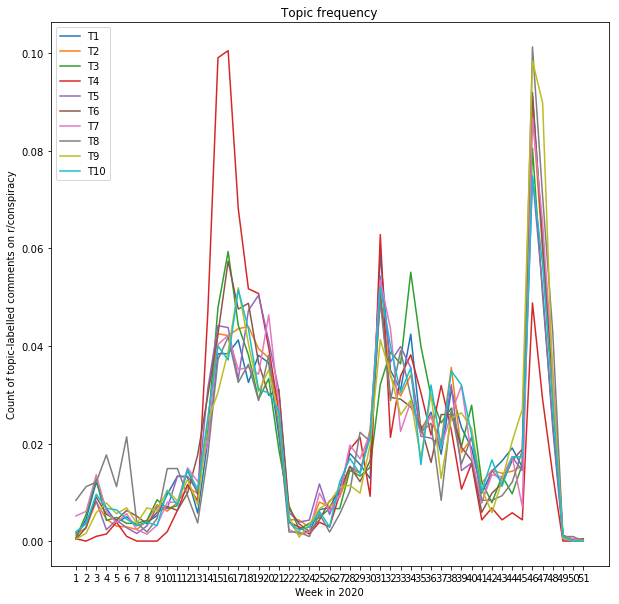

In [572]:
df_new = df_com_pp.groupby(['topic', 'week']).size().unstack('topic', fill_value = 0)
df_new = df_new[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']]

# # normalise by dividing each row by total coms that week
# for i in df_com_total.index:
#     df_new.loc[i] = df_new.loc[i]/df_com_total.loc[i]

# normalise by dividing each column by total coms of that topic
df_new = df_new.divide(df_new.sum(axis=0), axis = 'columns')

fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.plot(df_new.index,df_new)
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of topic-labelled comments on r/conspiracy')
ax.set_title('Topic frequency')
ax.legend(df_new.columns, loc='upper left')
# #plt.grid()
plt.show()


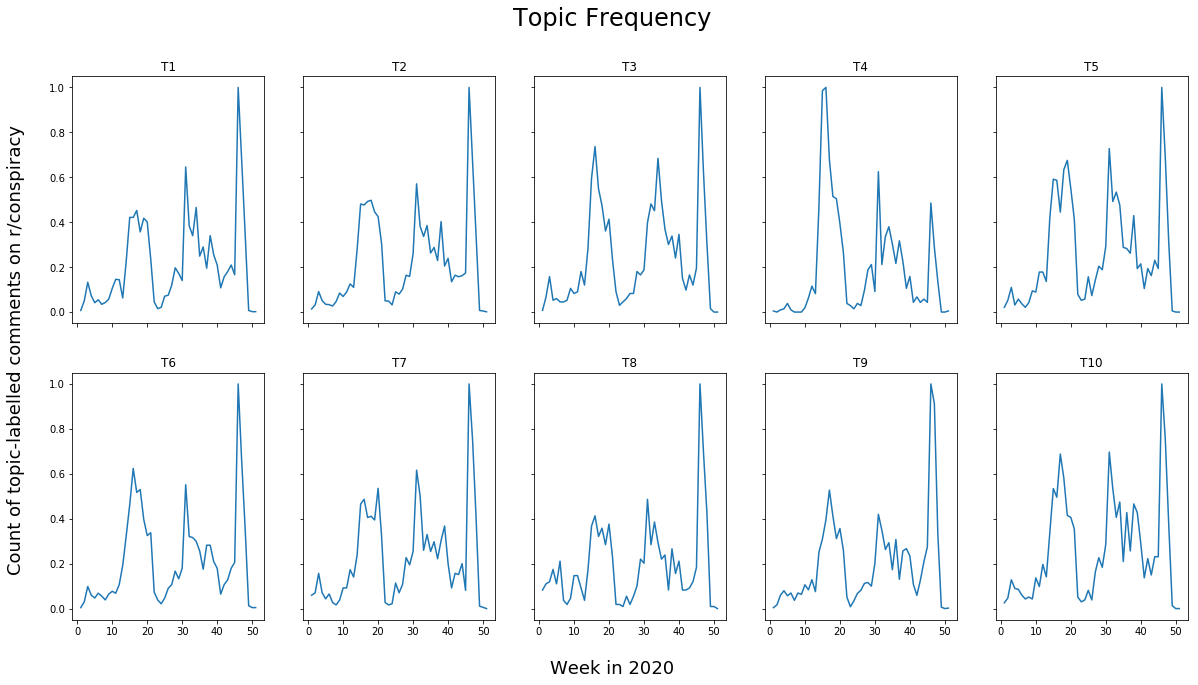

In [573]:
df_new = df_com_pp.groupby(['topic', 'week']).size().unstack('topic', fill_value = 0)
df_new = df_new[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']]

# normalise by dividing each column by max/total weekly count of comments with that topic
df_new = df_new.divide(df_new.max(axis=0), axis = 'columns')

fig, ax = plt.subplots(2,5, sharex='col', sharey='row')
fig.set_size_inches([20,10])
idx = 0
for i in range(2):
    for j in range(5):
        ax[i, j].plot(df_new.index,df_new.iloc[:,idx])
        ax[i, j].set_title(df_new.columns[idx])
        idx+=1
fig.text(0.5, 0.95, 'Topic Frequency', ha='center', fontsize=24)
fig.text(0.5, 0.05, 'Week in 2020', ha='center', fontsize=18)
fig.text(0.08, 0.5, 'Count of topic-labelled comments on r/conspiracy', va='center', rotation='vertical', fontsize=18)
plt.show()


---
## num_topics ( Non-negative Matrix Factorisation )

In [590]:
# Fucntion to find the best number of topics using coherence score. 
def test_NMFs(lower_topics = 4, upper_topics = 16, step_size = 2):
    num_models = (upper_topics - lower_topics) / step_size
    # Iterate through topic numbers to find an optimal number of topics
    mean_sim_scores = []
    models = {}
    count = 1
    for i in range(lower_topics, upper_topics, step_size): 
        print('Testing model', count, 'of', num_models)
        count += 1
#         nmf_model = NMF(n_components=i, solver='cd', max_iter=500,
#                         random_state=42, alpha=.1, l1_ratio=.85)
        nmf_model = NMF(n_components=i, init='nndsvd', max_iter=2000)
        nmf_model.fit_transform(cv_features)
        topic_terms_matrix = nmf_model.components_
        sim_matrix = cosine_similarity(topic_terms_matrix)
        mean_sim_scores.append(np.mean(sim_matrix))
        models[str(i)] = nmf_model

    # Plot the relationship between number of topics and the coherence score
    x = [i for i in range(lower_topics, upper_topics, step_size)]
    plt.figure(figsize=(16,9))
    plt.scatter(x, mean_sim_scores, marker='^', color='blue', label='Mean cosine similarity')
    plt.plot(x, [1/i for i in x], 'g',label=(r'$1/x$'))
    plt.scatter(x, [sim - 1/i for (sim,i) in zip(mean_sim_scores,x)], marker='o', color='red', label='Mean cs - 1/x')
    plt.xlabel('Number of Topics')
    plt.ylabel('Mean Pairwise Cosine Similarity Score')
    plt.axvline(x=30, c='black', ls='--')
    plt.legend()
    plt.show()
    
    return models, mean_sim_scores

Testing model 1 of 26.0
Testing model 2 of 26.0
Testing model 3 of 26.0
Testing model 4 of 26.0
Testing model 5 of 26.0
Testing model 6 of 26.0
Testing model 7 of 26.0
Testing model 8 of 26.0
Testing model 9 of 26.0
Testing model 10 of 26.0
Testing model 11 of 26.0
Testing model 12 of 26.0
Testing model 13 of 26.0
Testing model 14 of 26.0
Testing model 15 of 26.0
Testing model 16 of 26.0
Testing model 17 of 26.0
Testing model 18 of 26.0
Testing model 19 of 26.0
Testing model 20 of 26.0
Testing model 21 of 26.0
Testing model 22 of 26.0
Testing model 23 of 26.0
Testing model 24 of 26.0
Testing model 25 of 26.0
Testing model 26 of 26.0


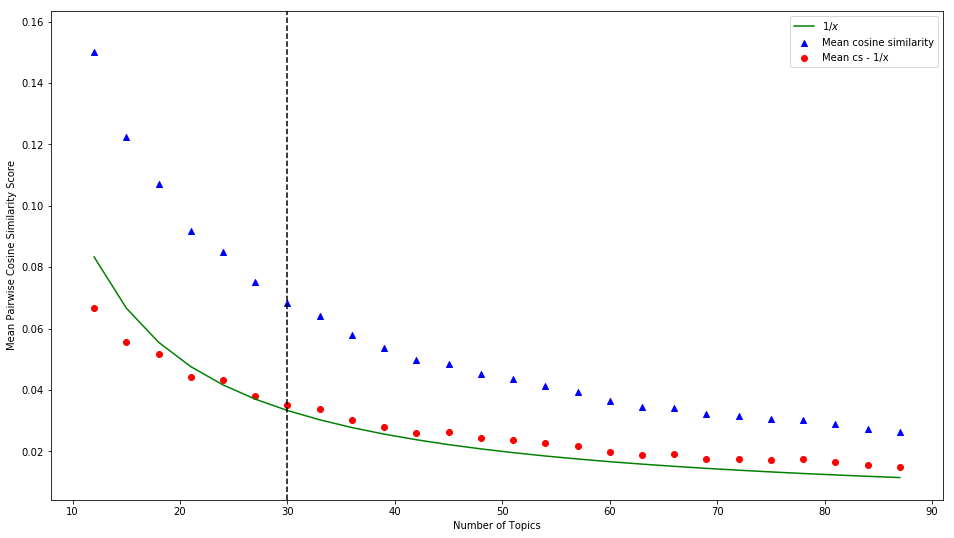

In [592]:
model_objs_NMF, sim_scores = test_NMFs(lower_topics = 12, upper_topics = 90, step_size = 3)

In [686]:
# choose 42, 45 or 48
model_nmf = model_objs_NMF['42']

* k-means clustering ([Source](https://github.com/rahulpawar0712/K-means-clustering-with-the-iris-data-example-/blob/master/A%20K-means%20clustering%20with%20the%20iris%20data%20example%20.ipynb))

In [593]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import seaborn as sns

In [594]:
document_topics = model_nmf.fit_transform(cv_features)

k_means_fit = KMeans(n_clusters=3,max_iter=300) 
k_means_fit.fit(document_topics)

KMeans(n_clusters=3)

In [596]:
print ("\nSilhouette-score: %0.3f" % silhouette_score(document_topics, k_means_fit.labels_, metric='euclidean'))


Silhouette-score: 0.973


In [598]:
silh_scores = []
k_range = range(2,30,2)
for k in k_range: 
    k_means_fitk = KMeans(n_clusters=k,max_iter=300) 
    k_means_fitk.fit(document_topics)
    ss = silhouette_score(document_topics, k_means_fitk.labels_, metric='euclidean')
    silh_scores.append(ss)
    print ("For K value",k,",Silhouette-score: %0.3f" % ss)

For K value 2 ,Silhouette-score: 0.977
For K value 4 ,Silhouette-score: 0.811
For K value 6 ,Silhouette-score: 0.728
For K value 8 ,Silhouette-score: 0.749
For K value 10 ,Silhouette-score: 0.649
For K value 12 ,Silhouette-score: 0.601
For K value 14 ,Silhouette-score: 0.500
For K value 16 ,Silhouette-score: 0.500
For K value 18 ,Silhouette-score: 0.508
For K value 20 ,Silhouette-score: 0.454
For K value 22 ,Silhouette-score: 0.513
For K value 24 ,Silhouette-score: 0.471
For K value 26 ,Silhouette-score: 0.464
For K value 28 ,Silhouette-score: 0.480


The silhouette coefficient values in the preceding results shows that K value 2 and K value 3 have better scores than all the other values. As a thumb rule, we need to take the next K value of the highest silhouette coefficient. Here, we can say that K value 3 is better. In addition, we also need to see the average within cluster variation value and elbow plot before concluding the optimal K value.

Text(0,0.5,'Silhouette Score')

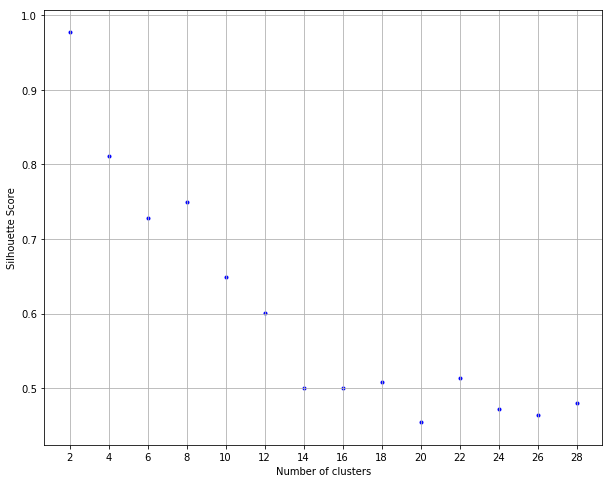

In [674]:
# silhouette scores
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
ax.scatter(k_range, silh_scores, c='blue', marker='.')
ax.set_xticks(k_range)
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette Score')

In [610]:
# Avg. within-cluster sum of squares 
KM = [KMeans(n_clusters=k).fit(document_topics) for k in k_range] 
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(document_topics, centrds, 'euclidean') for centrds in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k] 
dist = [np.min(D,axis=1) for D in D_k] 
avgWithinSS = [d.sum()/document_topics.shape[0] for d in dist]

In [635]:
len(dist[0])

71441

In [677]:
pdist(document_topics)

MemoryError: Unable to allocate 19.0 GiB for an array with shape (2551872520,) and data type float64

In [684]:
filename = data_dir + "\\" + 'document_topics.npy'
np.save(filename, document_topics)

In [683]:
# from fastdist import fastdist

# fastdist.matrix_pairwise_distance(document_topics, fastdist.euclidean, "euclidean", return_matrix=False)
# # returns an array of shape (10 choose 2, 1)
# # to return a matrix with entry (i, j) as the distance between row i and j
# # set return_matrix=True, in which case this will return a (10, 10) array

In [636]:
# Total with-in sum of square
wcss = [np.sum(d**2) for d in dist] 
tss = np.sum(pdist(document_topics)**2)/document_topics.shape[0] 
bss = tss-wcss

MemoryError: Unable to allocate 19.0 GiB for an array with shape (2551872520,) and data type float64

In [ ]:
# elbow curve - Avg. within-cluster sum of squares 
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.plot(k_range, avgWithinSS, 'b*-') 
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Average within-cluster sum of squares')

In [ ]:
# elbow curve - percentage of variance explained 
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax.plot(k_range, bss/tss*100, 'b*-') 
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Percentage of variance explained') 
plt.show()

In [619]:
from kmeans_gap import gapKMeans
l = gapKMeans(document_topics)

Gap value at  0 clusters:  0.0
Need to beat  391.0253736184467
Gap value at  1 clusters:  391.0253736184467
Need to beat  381.78723134976497
Gap value at  2 clusters:  381.7884671486339
Need to beat  382.7665581241016
Gap value at  3 clusters:  382.76756910791846
Need to beat  388.3363788225686
Gap value at  4 clusters:  388.33801913397053
Need to beat  396.858090045706
Gap value at  5 clusters:  396.85865519900346
Need to beat  405.49124888918914
Gap value at  6 clusters:  405.4919121828984
Need to beat  419.39732171846873
Gap value at  7 clusters:  419.3982304499835
Need to beat  435.70127750243284
Gap value at  8 clusters:  435.70188699081564
Need to beat  453.47096477231105
Gap value at  9 clusters:  453.47223078827255
Need to beat  466.9268028262149


KeyboardInterrupt: 

* Gap statistic
    * The gap statistic was developed by Stanford researchers Tibshirani, Walther and Hastie in their 2001 paper. The idea behind their approach was to find a way to standardize the comparison of \log W_k with a null reference distribution of the data, i.e. a distribution with no obvious clustering. Their estimate for the optimal number of clusters K is the value for which \log W_k falls the farthest below this reference curve. This information is contained in the following formula for the gap statistic:

     [Code](https://github.com/teruo41/calc_k_with_gap) 

    [Source](https://datasciencelab.wordpress.com/tag/gap-statistic/)
    
    alternate implementation ipynb ([Source](https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb))

In [652]:
import importlib
import calc_k_with_gap
importlib.reload(calc_k_with_gap)
from calc_k_with_gap import calc_k_with_gap

k, gaps, sks = calc_k_with_gap(document_topics, max_k=30)

calc_k_with_gap() preparing...
calc_k_with_gap() preparing...   Done.
calc_k_with_gap() iteration for i =  0
calc_k_with_gap() iteration for i =  1
calc_k_with_gap() iteration for i =  2
calc_k_with_gap() iteration for i =  3
calc_k_with_gap() iteration for i =  4
calc_k_with_gap() iteration for i =  5
calc_k_with_gap() iteration for i =  6
calc_k_with_gap() iteration for i =  7
calc_k_with_gap() iteration for i =  8
calc_k_with_gap() iteration for i =  9
calc_k_with_gap() iteration for i =  10
calc_k_with_gap() iteration for i =  11
calc_k_with_gap() iteration for i =  12
calc_k_with_gap() iteration for i =  13
calc_k_with_gap() iteration for i =  14
calc_k_with_gap() iteration for i =  15
calc_k_with_gap() iteration for i =  16
calc_k_with_gap() iteration for i =  17
calc_k_with_gap() iteration for i =  18
calc_k_with_gap() iteration for i =  19
calc_k_with_gap() iteration for i =  20
calc_k_with_gap() iteration for i =  21
calc_k_with_gap() iteration for i =  22
calc_k_with_gap() it

In [659]:
len(sks)

30

Text(0,0.5,'Gap stat')

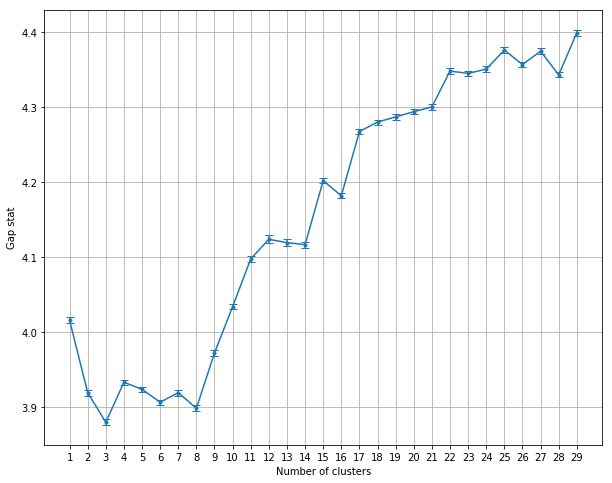

In [673]:
# gap stat
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)
#ax.scatter(range(1,k+1), gaps[:-1], c='blue', marker='.')
ax.errorbar(range(1,k+1), gaps[:-1],yerr=6*sks[:-1], capsize=4, marker='.')
ax.set_xticks(range(1,k+1))
plt.grid(True) 
plt.xlabel('Number of clusters') 
plt.ylabel('Gap stat')

---
---
---
## Parking lot
  * text analysis with python vid [link](https://www.youtube.com/watch?v=ALGd_frv4rc&feature=youtu.be&ab_channel=J%C3%BCrgenPfeffer)
  * SNA in python vids [link](https://www.youtube.com/playlist?list=PLW5N2mhH4QJqRKrHLWs052mhXyFAsQn-v) 

* pandas find word in str :

In [342]:
# find_word = 'aascsadv'
# df_com[df_com['text'].str.contains(find_word, case=False)]['text'].tolist()

* pandas find token in list :

In [343]:
# find_tkn = '2020comentcomit'  
# df_temp = df_com_pp[df_com_pp.apply(lambda x: find_tkn in x['text'], axis=1)][['text','text_og','link']]

# find_tkn_ind = df_temp.iloc[0, df_temp.columns.get_loc('text')].index(find_tkn)
# print(find_tkn_ind)
# df_temp.iloc[0, df_temp.columns.get_loc('text')][find_tkn_ind-5:find_tkn_ind+5]

# df_temp.iloc[0,df_temp.columns.get_loc('text_og')]

* Pandas positional and label-based indexing :

In [344]:
# df_temp.iloc[0, df_temp.columns.get_loc('text')][40:50]
# dfd.iloc[[0, 2], dfd.columns.get_indexer(['A', 'B'])]
# dfd.loc[dfd.index[[0, 2]], 'A']

* Display df unlimited

In [345]:
# with pd.option_context('display.max_colwidth', None):
#     #pd.set_option('display.max_columns', None)
#     display(df_temp)

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis

SVD -> NMF

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Construct a face with linear combinations of features
Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

In [589]:
# from sklearn.metrics.pairwise import cosine_similarity
# import math

# def nCr(n,r):
#     f = math.factorial
#     return f(n) // f(r) // f(n-r)

# def mean_pairwise_cosine_sim(topic_terms, num_topics):
#     sim_matrix = cosine_similarity(topic_terms) # Construct a topic similarity matrix
#     return np.mean(sim_matrix) # Get Mean pairwise cosine similarity for each vector in the topic-word mapping 
#     #return np.tril(sim_matrix, -1).sum()/nCr(num_topics, 2) # Get Mean pairwise cosine similarity for each vector in the topic-word mapping 

In [ ]:
# import dill
# filename = data_dir + "\\" + 'notebook_session_02_02_1251.db'
# dill.dump_session(filename)
# #dill.load_session('notebook_session.db')